In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer 
import matplotlib.pylab as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from numpy import interp

__Naive Bayes: with imputation__

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df = pd.read_csv('bank-data/bank-additional-full.csv')
print(df.shape)
print(df.columns)
print((df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] == 'unknown').sum())

df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].replace('unknown', np.NaN)
print(df.isnull().sum())

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month        

C:\Python3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
bank_object_data = df.select_dtypes(include="object")
print(bank_object_data.info())

bank_non_object_data = df.select_dtypes(exclude="object")
print(bank_non_object_data.info())

values = bank_non_object_data.values
#imputer = Imputer()
transformed_values = imputer.fit_transform(values)
# count the number of NaN values in each column
print(np.isnan(transformed_values).sum())
print(np.isnan(bank_non_object_data.values).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
job            40858 non-null object
marital        41108 non-null object
education      39457 non-null object
default        32591 non-null object
housing        40198 non-null object
loan           40198 non-null object
contact        41188 non-null object
month          41188 non-null object
day_of_week    41188 non-null object
poutcome       41188 non-null object
y              41188 non-null object
dtypes: object(11)
memory usage: 3.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
age               41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m  

In [13]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


bank_object_data = DataFrameImputer().fit_transform(bank_object_data)

In [14]:
label = LabelEncoder()
bank_object_data = bank_object_data.apply(label.fit_transform)

print(bank_object_data.head())

bank_final = pd.concat([bank_object_data, bank_non_object_data], axis = 1)

print(bank_final.head())

   job  marital  education  default  housing  loan  contact  month  \
0    3        1          0        0        0     0        1      6   
1    7        1          3        0        0     0        1      6   
2    7        1          3        0        1     0        1      6   
3    0        1          1        0        0     0        1      6   
4    7        1          3        0        0     1        1      6   

   day_of_week  poutcome  y  
0            1         1  0  
1            1         1  0  
2            1         1  0  
3            1         1  0  
4            1         1  0  
   job  marital  education  default  housing  loan  contact  month  \
0    3        1          0        0        0     0        1      6   
1    7        1          3        0        0     0        1      6   
2    7        1          3        0        1     0        1      6   
3    0        1          1        0        0     0        1      6   
4    7        1          3        0        0     

__Naive Bayes: with imputation; k fold and shuffle__

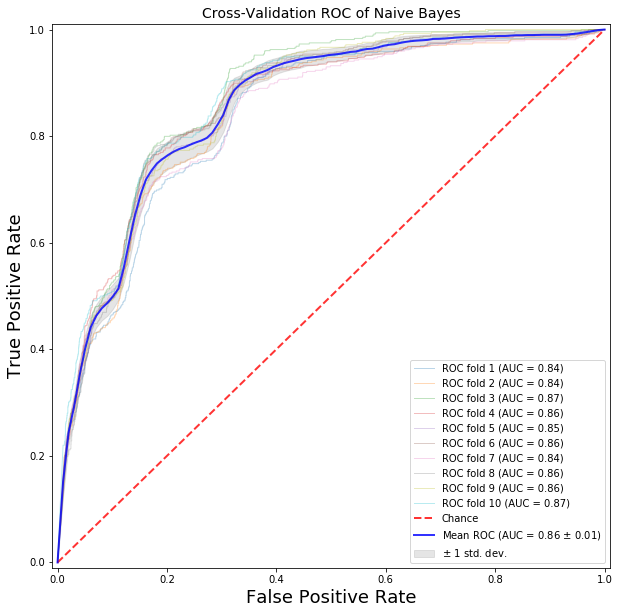

In [15]:
X_train_res = bank_final.drop(['y'], axis = 1)
y_train_res = bank_final['y']

cv = KFold(n_splits=10, random_state=100, shuffle = True)
classifier = GaussianNB()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 1
for train, test in cv.split(X_train_res, y_train_res):
    probas_ = classifier.fit(X_train_res.iloc[train], y_train_res.iloc[train]).predict_proba(X_train_res.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Naive Bayes',fontsize=14)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()